# 🐑 Sheep Classification with EfficientNetV2-S + Stratified K-Fold + Softmax Ensembling

This notebook presents a pipeline for classifying 7 sheep breeds using:
- 🧠 **EfficientNetV2-S** as the base CNN model
- 🔁 **Stratified K-Fold Cross-Validation** for robust training
- 🎭 **Data Augmentation** for better generalization
- ⚖️ **Class-Weighted Loss** to address imbalance
- 🧩 **Softmax Ensembling** weighted by F1 score for test inference

---


# Imports, Hyperparameters & Paths Setup

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import torch.nn.functional as F
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Hyperparameters & Device 
SEED = 42
NUM_CLASSES = 7
NUM_FOLDS = 5
BATCH_SIZE = 32
NUM_EPOCHS = 30
IMG_SIZE = 300 #384
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility Setup
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

# Paths & Label Mapping  
label_map = {"Naeimi": 0, "Goat": 1, "Sawakni": 2, "Roman": 3, "Najdi": 4, "Harri": 5, "Barbari": 6}
inv_label_map = {v: k for k, v in label_map.items()}

DATA_DIR = "/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
LABELS_CSV = os.path.join(DATA_DIR, "train_labels.csv")

df = pd.read_csv(LABELS_CSV)

# Exploratory Data Analysis (EDA)

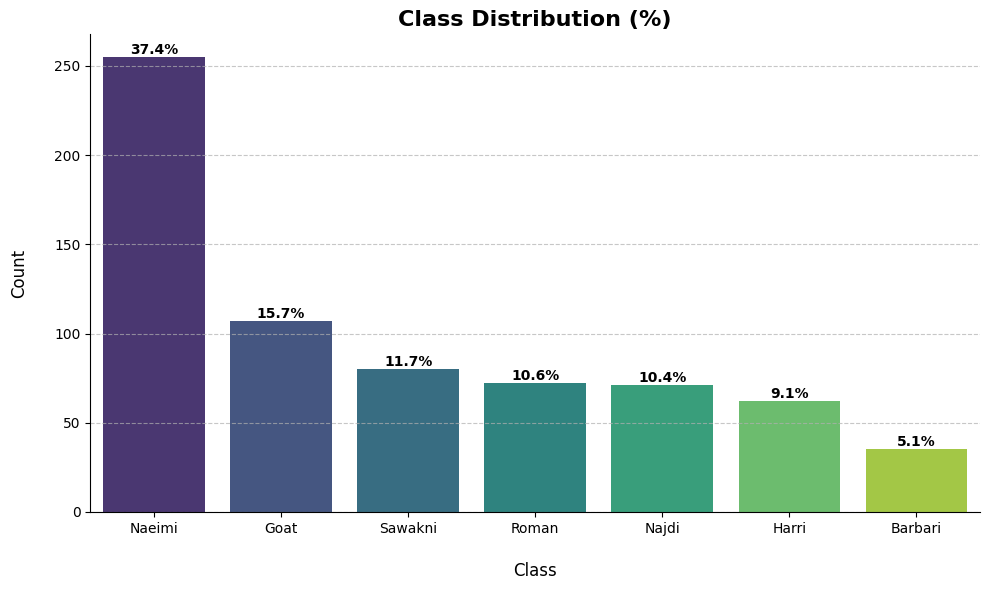

In [4]:
# Class Distribution (%)
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x='label',
    order=df['label'].value_counts().index,
    palette='viridis'
)

# Title and axis labels
plt.title("Class Distribution (%)", fontsize=16, fontweight='bold')
plt.xlabel("\nClass", fontsize=12)
plt.ylabel("Count\n", fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Add percentage labels above bars
total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = f"{100 * count / total:.1f}%"
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., count),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black',
        fontweight='bold'
    )

# Add gridlines for readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right borders
sns.despine()
plt.tight_layout()
plt.savefig("/kaggle/working/Class_Distribution.png", dpi=300)
plt.show()


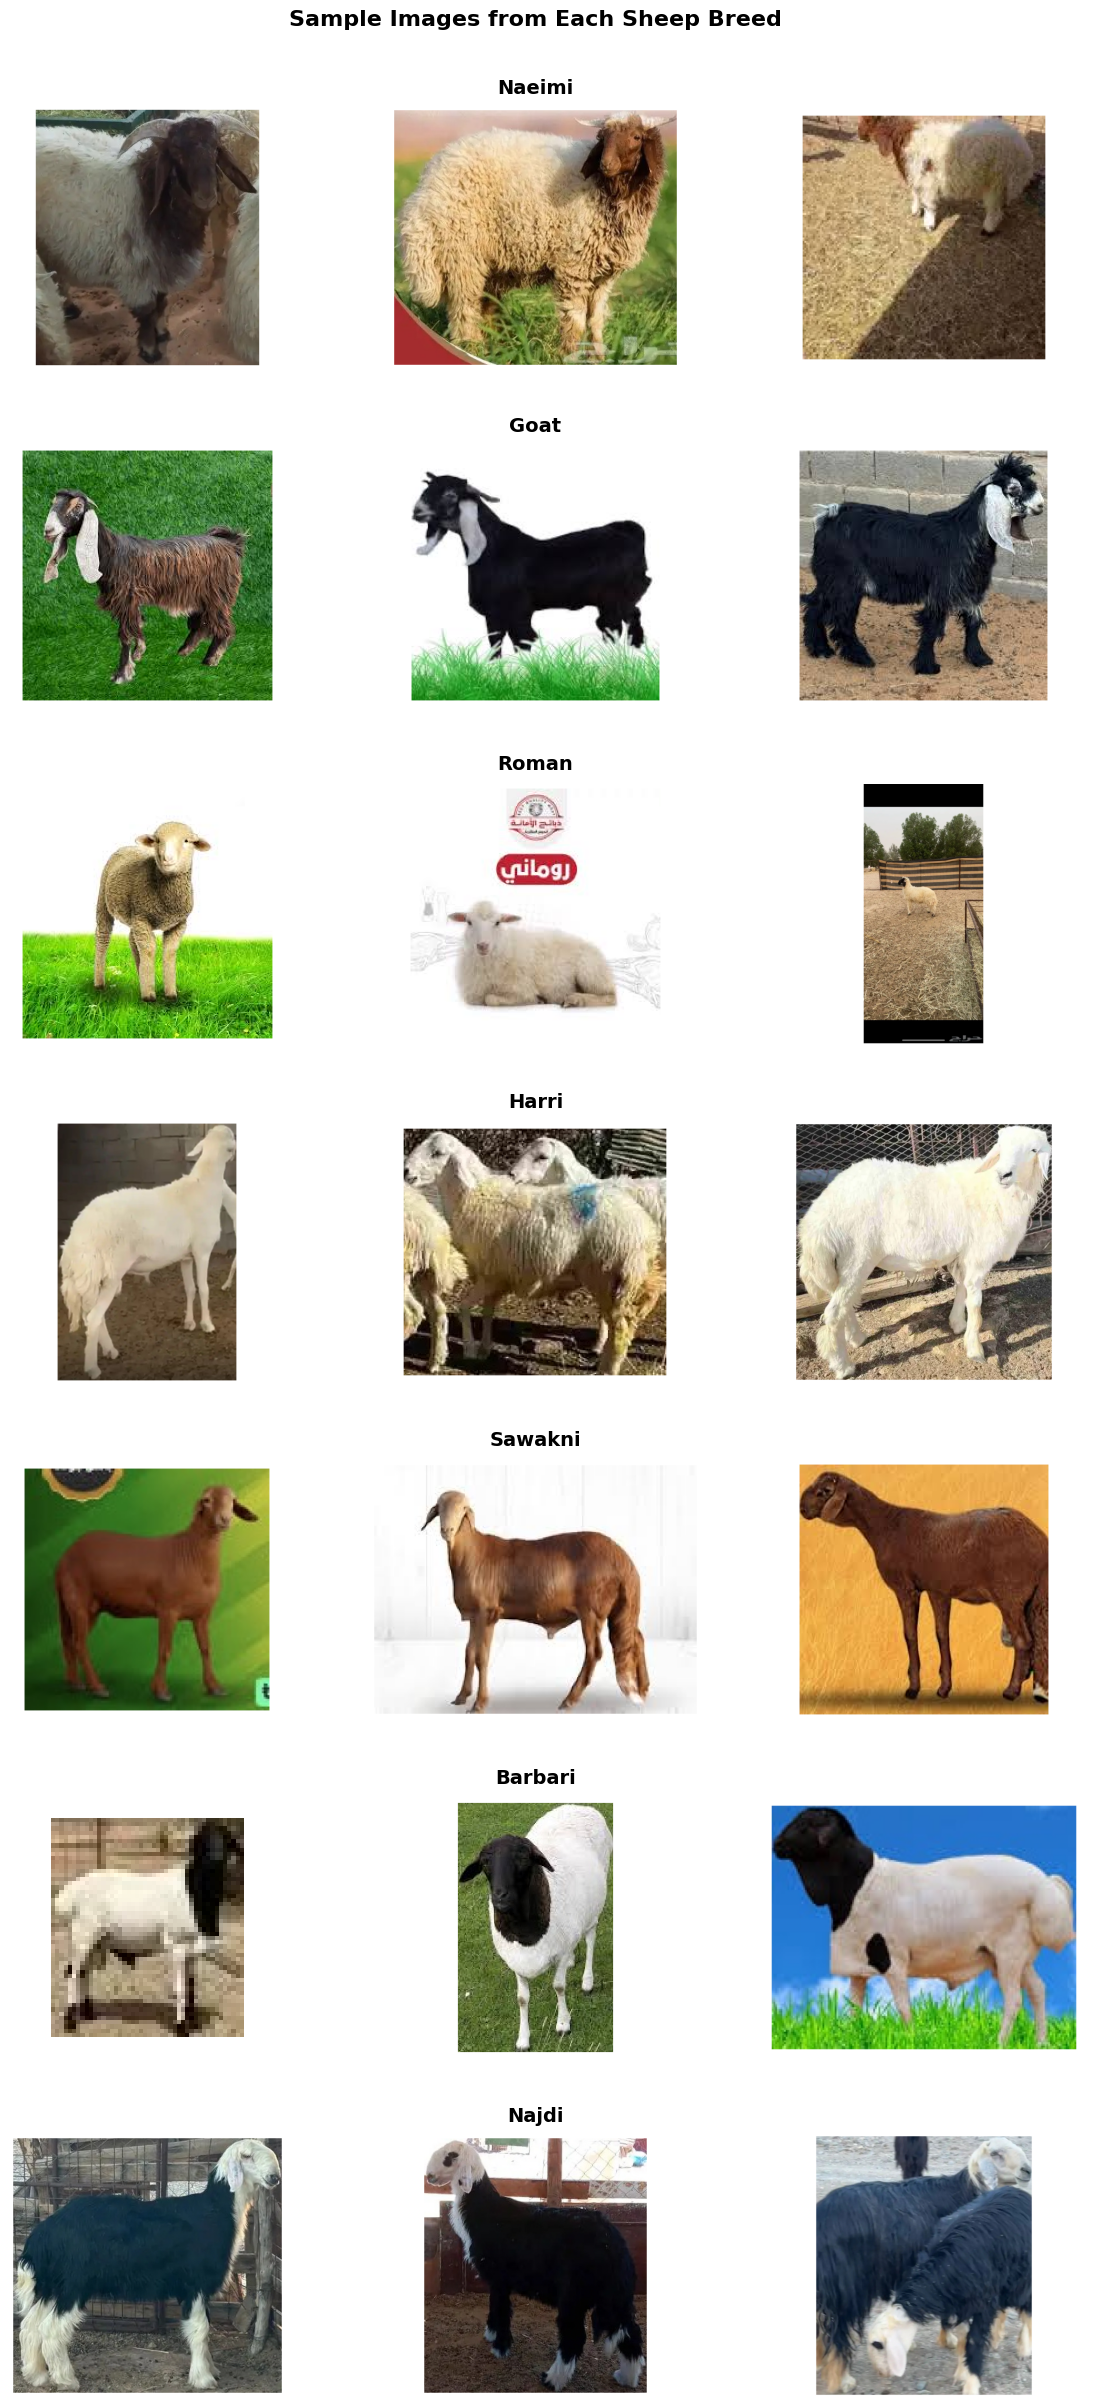

In [5]:
# Sample Images from Each Class  
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

num_samples = 3  # number of images per class
classes = df['label'].unique()
n_classes = len(classes)

plt.figure(figsize=(num_samples * 4, n_classes * 3.5))  

for row_idx, label in enumerate(classes):
    sample_df = df[df['label'] == label].sample(num_samples, random_state=SEED)
    
    for col_idx, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(TRAIN_DIR, row['filename'])
        image = Image.open(img_path).convert("RGB")
        image = ImageOps.expand(image, border=5, fill='white')  

        ax = plt.subplot(n_classes, num_samples, row_idx * num_samples + col_idx + 1)
        ax.imshow(image)
        ax.axis("off")

        if col_idx == 1:
            ax.set_title(label, fontsize=14, fontweight='bold', pad=10)

plt.suptitle("Sample Images from Each Sheep Breed", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.94, hspace=0.3)
plt.savefig("/kaggle/working/Sample_Sheep.png", dpi=300)

plt.show()

# Model Pipeline: Transforms, Dataset, Model, and K-Fold Training

In [6]:
# Data Augmentation & Normalization
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Improve robustness with color variations
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# loads images and applies transforms
class SheepDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert("RGB")
        label = label_map[self.df.iloc[idx]['label']]
        if self.transform: image = self.transform(image)
        return image, label

class TestDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image


# EfficientNetV2-S pretrained on ImageNet, adjusted for 7 classes
def get_model():
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = efficientnet_v2_s(weights=weights)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    return model

# Training with Stratified K-Fold
all_labels = df['label'].map(label_map).values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
    print(f"\n--- Fold {fold+1} ---")
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(SheepDataset(train_df, TRAIN_DIR, train_transform), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(SheepDataset(val_df, TRAIN_DIR, val_transform), batch_size=BATCH_SIZE, shuffle=False)

    model = get_model().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weights) # Use class-weighted CrossEntropyLoss to handle class imbalance
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    best_f1, early_stop = 0, 0
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_preds, train_labels = [], []
        for x, y in tqdm(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_preds.extend(out.argmax(1).cpu().numpy())
            train_labels.extend(y.cpu().numpy())
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(DEVICE)
                out = model(x)
                val_preds.extend(out.argmax(1).cpu().numpy())
                val_labels.extend(y.numpy())
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        scheduler.step(val_f1)
        print(f"Epoch {epoch+1}: Train F1={train_f1:.4f}, Val F1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"/kaggle/working/model_fold{fold}.pth")
            early_stop = 0
        else:
            early_stop += 1
        if early_stop >= PATIENCE:
            print("Early stopping.")
            break



--- Fold 1 ---


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 219MB/s]
100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


Epoch 1: Train F1=0.3810, Val F1=0.5471


100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


Epoch 2: Train F1=0.7235, Val F1=0.8199


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 3: Train F1=0.8762, Val F1=0.8956


100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch 4: Train F1=0.9295, Val F1=0.8996


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 5: Train F1=0.9504, Val F1=0.9377


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 6: Train F1=0.9742, Val F1=0.9377


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 7: Train F1=0.9859, Val F1=0.9228


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 8: Train F1=0.9774, Val F1=0.9377


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 9: Train F1=0.9787, Val F1=0.9377


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 10: Train F1=0.9876, Val F1=0.9377
Early stopping.

--- Fold 2 ---


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 1: Train F1=0.3905, Val F1=0.6481


100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


Epoch 2: Train F1=0.7703, Val F1=0.7039


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 3: Train F1=0.8636, Val F1=0.8400


100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch 4: Train F1=0.9274, Val F1=0.8865


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 5: Train F1=0.9711, Val F1=0.9115


100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch 6: Train F1=0.9824, Val F1=0.8810


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 7: Train F1=0.9786, Val F1=0.9427


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 8: Train F1=0.9811, Val F1=0.9084


100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


Epoch 9: Train F1=0.9835, Val F1=0.8876


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 10: Train F1=0.9900, Val F1=0.9137


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 11: Train F1=0.9932, Val F1=0.8971


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 12: Train F1=0.9824, Val F1=0.9324
Early stopping.

--- Fold 3 ---


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 1: Train F1=0.3116, Val F1=0.6680


100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


Epoch 2: Train F1=0.7353, Val F1=0.8259


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 3: Train F1=0.8631, Val F1=0.8604


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 4: Train F1=0.9003, Val F1=0.8915


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 5: Train F1=0.9372, Val F1=0.8747


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 6: Train F1=0.9511, Val F1=0.9316


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 7: Train F1=0.9701, Val F1=0.9564


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 8: Train F1=0.9696, Val F1=0.9414


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 9: Train F1=0.9703, Val F1=0.9581


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 10: Train F1=0.9799, Val F1=0.9529


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 11: Train F1=0.9956, Val F1=0.9592


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 12: Train F1=0.9876, Val F1=0.9611


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 13: Train F1=0.9909, Val F1=0.9648


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Epoch 14: Train F1=0.9884, Val F1=0.9113


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 15: Train F1=0.9793, Val F1=0.9372


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Epoch 16: Train F1=0.9928, Val F1=0.9530


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 17: Train F1=0.9866, Val F1=0.9425


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


Epoch 18: Train F1=0.9933, Val F1=0.9401
Early stopping.

--- Fold 4 ---


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 1: Train F1=0.4103, Val F1=0.7872


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 2: Train F1=0.7601, Val F1=0.8672


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 3: Train F1=0.8812, Val F1=0.9126


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 4: Train F1=0.9261, Val F1=0.8978


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 5: Train F1=0.9610, Val F1=0.9514


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 6: Train F1=0.9840, Val F1=0.9548


100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


Epoch 7: Train F1=0.9831, Val F1=0.9654


100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


Epoch 8: Train F1=0.9791, Val F1=0.9475


100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


Epoch 9: Train F1=0.9810, Val F1=0.9478


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 10: Train F1=0.9755, Val F1=0.9529


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 11: Train F1=0.9879, Val F1=0.9385


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 12: Train F1=0.9858, Val F1=0.9478
Early stopping.

--- Fold 5 ---


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 1: Train F1=0.3708, Val F1=0.7058


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 2: Train F1=0.7659, Val F1=0.8311


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 3: Train F1=0.8765, Val F1=0.8947


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 4: Train F1=0.9114, Val F1=0.9213


100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


Epoch 5: Train F1=0.9499, Val F1=0.9499


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 6: Train F1=0.9660, Val F1=0.9666


100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


Epoch 7: Train F1=0.9825, Val F1=0.9768


100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


Epoch 8: Train F1=0.9783, Val F1=0.9549


100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


Epoch 9: Train F1=0.9794, Val F1=0.9588


100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


Epoch 10: Train F1=0.9690, Val F1=0.9648


100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


Epoch 11: Train F1=0.9784, Val F1=0.9540


100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


Epoch 12: Train F1=0.9818, Val F1=0.9482
Early stopping.


# Final Evaluation & Confusion Matrix

In [9]:
print("\n--- Validation Performance Across Folds ---")

all_probs, all_preds, all_labels = [], [], []
fold_scores = [] 

def compute_ece(probs, labels, n_bins=15):
    """Compute Expected Calibration Error (ECE)."""
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)

    ece = 0.0
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        mask = (confidences > bin_lower) & (confidences <= bin_upper)

        if np.any(mask):
            bin_accuracy = np.mean(accuracies[mask])
            bin_confidence = np.mean(confidences[mask])
            ece += (np.sum(mask) / len(probs)) * np.abs(bin_confidence - bin_accuracy)

    return ece

for fold, (_, val_idx) in enumerate(skf.split(df, df['label'])):
    val_df = df.iloc[val_idx].reset_index(drop=True)
    val_loader = DataLoader(SheepDataset(val_df, TRAIN_DIR, val_transform), batch_size=BATCH_SIZE, shuffle=False)

    model = get_model().to(DEVICE)
    model.load_state_dict(torch.load(f"/kaggle/working/model_fold{fold}.pth"))
    model.eval()

    fold_probs, fold_preds, fold_labels = [], [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            out = model(x)
            probs = torch.softmax(out, dim=1).cpu().numpy()
            fold_probs.extend(probs)
            fold_preds.extend(np.argmax(probs, axis=1))
            fold_labels.extend(y.numpy())

    all_probs.extend(fold_probs)
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    f1 = f1_score(fold_labels, fold_preds, average='macro')
    print(f"Fold {fold+1} F1 Score: {f1:.4f}")
    fold_scores.append(f1)

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))


--- Validation Performance Across Folds ---
Fold 1 F1 Score: 0.9377
Fold 2 F1 Score: 0.9427
Fold 3 F1 Score: 0.9648
Fold 4 F1 Score: 0.9654
Fold 5 F1 Score: 0.9768

--- Classification Report ---
              precision    recall  f1-score   support

      Naeimi       0.98      0.96      0.97       255
        Goat       0.97      0.97      0.97       107
     Sawakni       0.98      0.99      0.98        80
       Roman       0.85      0.89      0.87        72
       Najdi       1.00      1.00      1.00        71
       Harri       0.97      0.94      0.95        62
     Barbari       0.94      0.97      0.96        35

    accuracy                           0.96       682
   macro avg       0.96      0.96      0.96       682
weighted avg       0.96      0.96      0.96       682



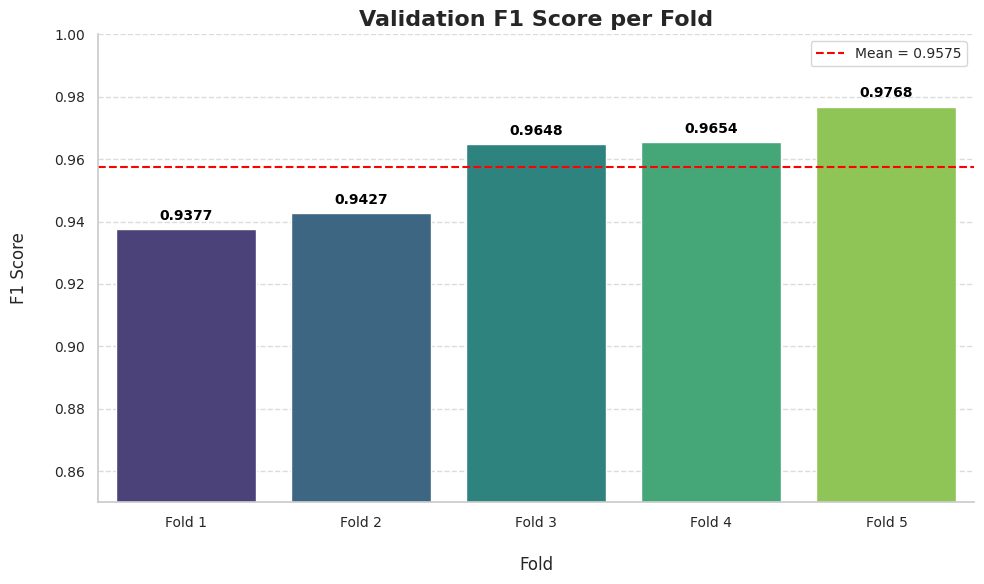

In [11]:
# Visualize validation F1 score for each fold using a bar chart 
sns.set(style="whitegrid")
x_labels = np.array([f'Fold {i+1}' for i in range(NUM_FOLDS)])
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=x_labels,
                      y=fold_scores,
                      palette='viridis')
mean_score = np.mean(fold_scores)
plt.axhline(mean_score, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean_score:.4f}")

# Annotate each bar with the corresponding F1 score
for i, score in enumerate(fold_scores):
    plt.text(i, score + 0.002, f"{score:.4f}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title("Validation F1 Score per Fold", fontsize=16, fontweight='bold')
plt.xlabel("\nFold", fontsize=12)
plt.ylabel("F1 Score\n", fontsize=12)
plt.ylim(0.85, 1.0)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
barplot.yaxis.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("/kaggle/working/f1_per_fold.png", dpi=300)
plt.show()

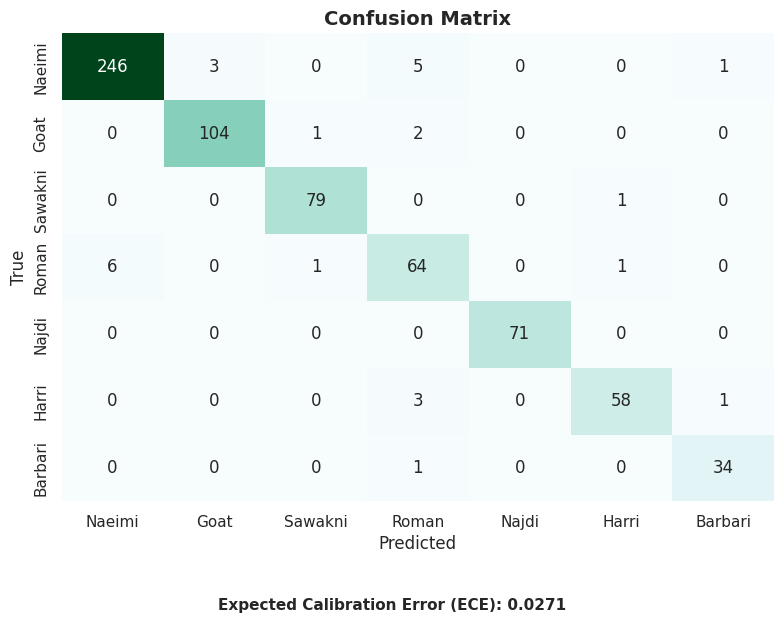

In [26]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="BuGn",
            xticklabels=label_map.keys(), yticklabels=label_map.keys(),
            cbar=False)

plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted\n", fontsize=12)
plt.ylabel("True", fontsize=12)

# Compute ECE
ece_score = compute_ece(np.array(all_probs), np.array(all_labels))

# Add ECE below the plot (centered)
plt.figtext(0.5, -0.03, f"Expected Calibration Error (ECE): {ece_score:.4f}",
            ha="center", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("/kaggle/working/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


# Inference on Test Set using Weighted Softmax Ensembling

In [27]:
print("\n--- Inference on Test Set ---")
test_files = sorted(os.listdir(TEST_DIR))
test_df = pd.DataFrame({"filename": test_files})
test_loader = DataLoader(TestDataset(test_df, TEST_DIR, val_transform), batch_size=BATCH_SIZE, shuffle=False)

all_outputs = []
fold_f1_scores = []

for fold, (_, val_idx) in enumerate(skf.split(df, df['label'])):
    print(f"Inferencing with Fold {fold+1} model...")
    model = get_model().to(DEVICE)
    model.load_state_dict(torch.load(f"/kaggle/working/model_fold{fold}.pth"))
    model.eval()

    outputs = []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(DEVICE)
            out = model(images)
            outputs.append(torch.softmax(out, dim=1).cpu().numpy())
    all_outputs.append(np.concatenate(outputs))

    val_df = df.iloc[val_idx].reset_index(drop=True)
    val_loader = DataLoader(SheepDataset(val_df, TRAIN_DIR, val_transform), batch_size=BATCH_SIZE, shuffle=False)

    val_preds, val_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            out = model(x)
            val_preds.extend(out.argmax(1).cpu().numpy())
            val_labels.extend(y.numpy())
    f1 = f1_score(val_labels, val_preds, average="macro")
    fold_f1_scores.append(f1)
    print(f"Fold {fold+1} Val F1: {f1:.4f}")

# Softmax ensembling: combine predictions from folds weighted by validation F1 scores
weights = np.array(fold_f1_scores)
weights = weights / weights.sum()

weighted_output = np.zeros_like(all_outputs[0])
for i in range(NUM_FOLDS):
    weighted_output += all_outputs[i] * weights[i]

final_preds = np.argmax(weighted_output, axis=1)
final_labels = [inv_label_map[p] for p in final_preds]

submission = pd.DataFrame({"filename": test_files, "label": final_labels})
submission.to_csv("/kaggle/working/submission.csv", index=False)
print("Saved weighted averaged submission to submission.csv")


--- Inference on Test Set ---
Inferencing with Fold 1 model...
Fold 1 Val F1: 0.9377
Inferencing with Fold 2 model...
Fold 2 Val F1: 0.9427
Inferencing with Fold 3 model...
Fold 3 Val F1: 0.9648
Inferencing with Fold 4 model...
Fold 4 Val F1: 0.9654
Inferencing with Fold 5 model...
Fold 5 Val F1: 0.9768
Saved weighted averaged submission to submission.csv
